In [2]:
import pandas as pd
import numpy as np
import bokeh as bh
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
train = pd.read_hdf("../input/train_elo_world.hd5","train")
test = pd.read_hdf("../input/train_elo_world.hd5","test")
target = pd.read_csv("../input/train.csv.zip",usecols=['target'],squeeze=True)
train["target"] = target

features = [c for c in train.columns if c not in ['card_id', 'first_active_month','target']]


In [6]:
train_agg = train[features].describe().T
train_agg["missing"] = train.isna().sum(axis=0) / train.shape[0]

test_agg = test[features].describe().T
test_agg["missing"] = test.isna().sum(axis=0) / test.shape[0]


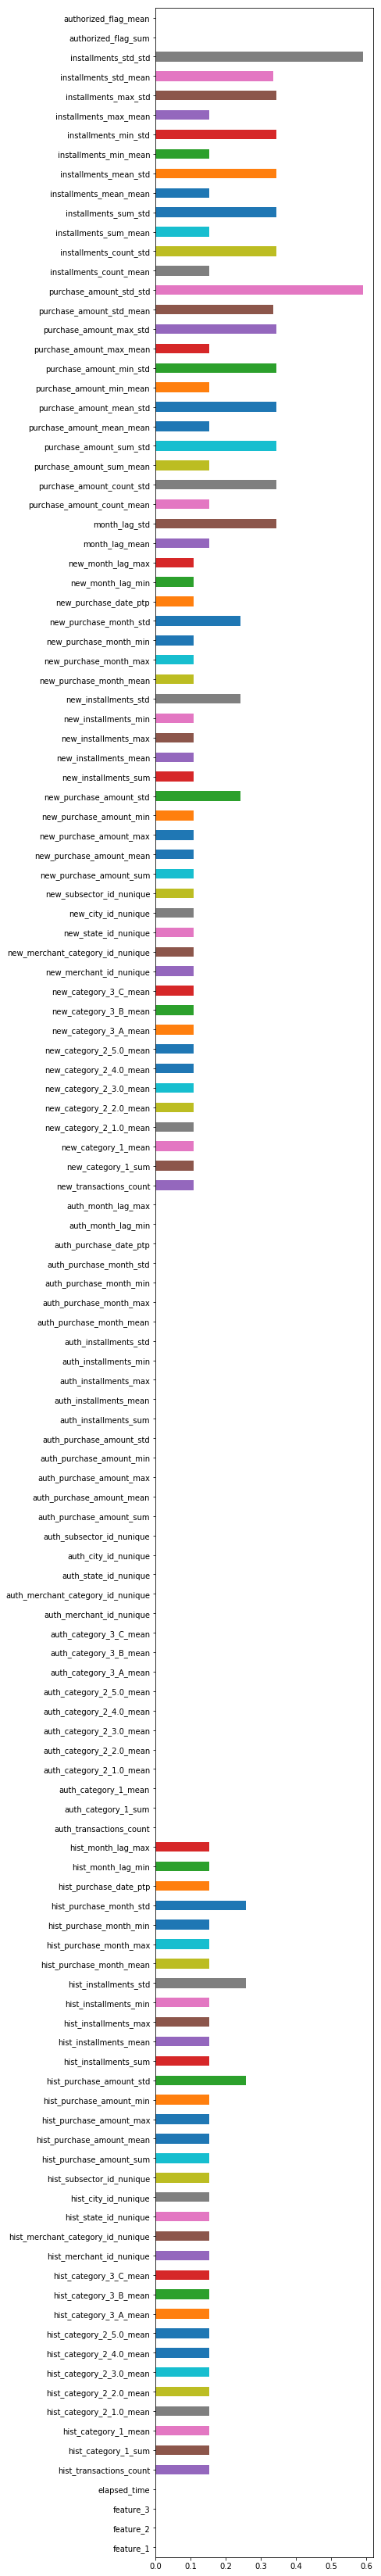

In [7]:
train_agg["missing"].plot.barh(figsize=(5,60))

In [8]:
train_agg["std"] /= train_agg["mean"]

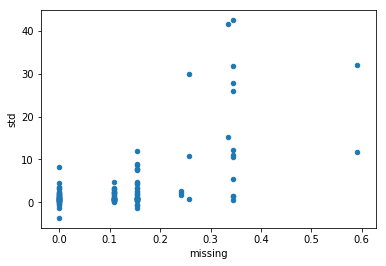

In [9]:
train_agg.plot.scatter("missing","std")

In [10]:
train_isna = train[features].isna()
test_isna = test[features].isna()

# for feature in train.columns:
    

In [11]:
def encode(x):
    encoded = 0
    for pos,val in enumerate(x):
        encoded += val*pos**2
    return encoded
train_nacat = train_isna.apply(encode,raw=True,axis=1)
test_nacat = test_isna.apply(encode,raw=True,axis=1)


In [12]:
train_cats = train_nacat.unique()
test_cats = train_nacat.unique()

train_cats == test_cats

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [41]:
train["nacat"] = train_nacat
test["nacat"] = test_nacat


In [14]:
gbna = train.groupby("nacat")

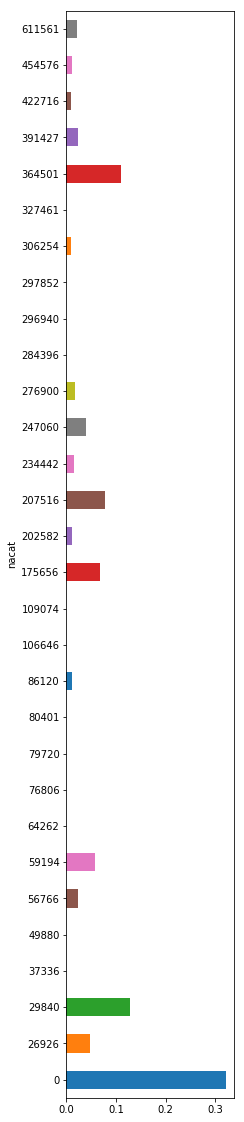

In [15]:
((gbna["target"].describe()["count"])/train.shape[0]).plot.barh(figsize=(3,20))

In [16]:
agg_target_by_cat = gbna["target"].describe()

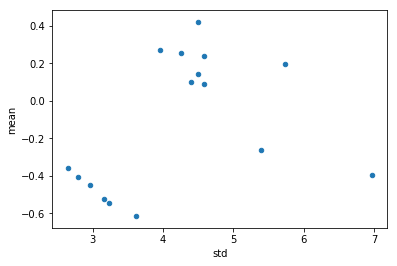

In [17]:
agg_target_by_cat[agg_target_by_cat["count"]/target.shape[0]>0.01].plot.scatter("std","mean")

In [19]:
relevant_cats = agg_target_by_cat[agg_target_by_cat["count"]/target.shape[0]>0.05]

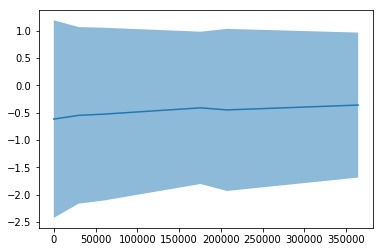

In [20]:
plt.plot(relevant_cats.index,relevant_cats["mean"])
plt.fill_between(relevant_cats.index,relevant_cats["mean"]-relevant_cats["std"]*0.5,relevant_cats["mean"]+relevant_cats["std"]*0.5,alpha=0.5)

In [21]:
pred = train["nacat"].apply(lambda x: agg_target_by_cat.loc[x,"mean"])

In [22]:
np.sqrt( ((pred-train["target"])**2).mean() )/target.std()

0.9971338591518297

In [23]:
relevant_cats = agg_target_by_cat[agg_target_by_cat["count"]/target.shape[0]>0.05]
relevant_cats

,count,mean,std,min,25%,50%,75%,max
nacat,,,,,,,,
0,64810.0,-0.614928,3.616956,-33.219281,-0.923297,-0.150686,0.486283,10.571836
29840,25830.0,-0.546550,3.230360,-33.219281,-1.001519,-0.164648,0.542316,6.606855
59194,11586.0,-0.525017,3.163888,-33.219281,-1.024255,-0.165290,0.555228,6.742258
175656,13507.0,-0.409404,2.787474,-33.219281,-0.960103,-0.126457,0.571539,6.511625
207516,15472.0,-0.447289,2.965948,-33.219281,-1.000129,-0.142773,0.623787,7.691796
364501,21978.0,-0.358430,2.653488,-33.219281,-0.996374,-0.115503,0.667970,8.389209


In [24]:
from sklearn.preprocessing import  OneHotEncoder

In [25]:
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [26]:
enc.fit(relevant_cats.index.values.reshape(-1,1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='ignore', n_values='auto', sparse=False)

In [42]:
train_nacat_encoded = pd.DataFrame( enc.transform(train[["nacat"]]) )

train_nacat_encoded.columns = ["feature_nacat_%d" %icat for icat in range(train_nacat_encoded.shape[1])]

train = train.join(train_nacat_encoded)

del train["nacat"]
del train["target"]

In [43]:
test_nacat_encoded = pd.DataFrame( enc.transform(test[["nacat"]]) )

test_nacat_encoded.columns = ["feature_nacat_%d" %icat for icat in range(test_nacat_encoded.shape[1])]

test = test.join(test_nacat_encoded)

del test["nacat"]

In [44]:
train.to_hdf("../input/train_elo_world_nacat.hd5","train")
test.to_hdf("../input/train_elo_world_nacat.hd5","test")
